# 16. Segmentation map으로 도로 이미지 만들기

2014년 GAN(Generative Adbersarial Networks)가 발표된 이후 Computer Vision 및 다양한 많은 분야에서 관심을 받아 활발하게 발전해왔습니다. 이미지 생성모델로 사용되는 일반적인 GAN에 조건을 부여하여 내가 원하는 유형의 이미지를 생성해 낼 수 있도록 하는 방법에 대해 실습합니다. 

## (1) 데이터 준비하기
---

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


1000개의 이미지가 있습니다!

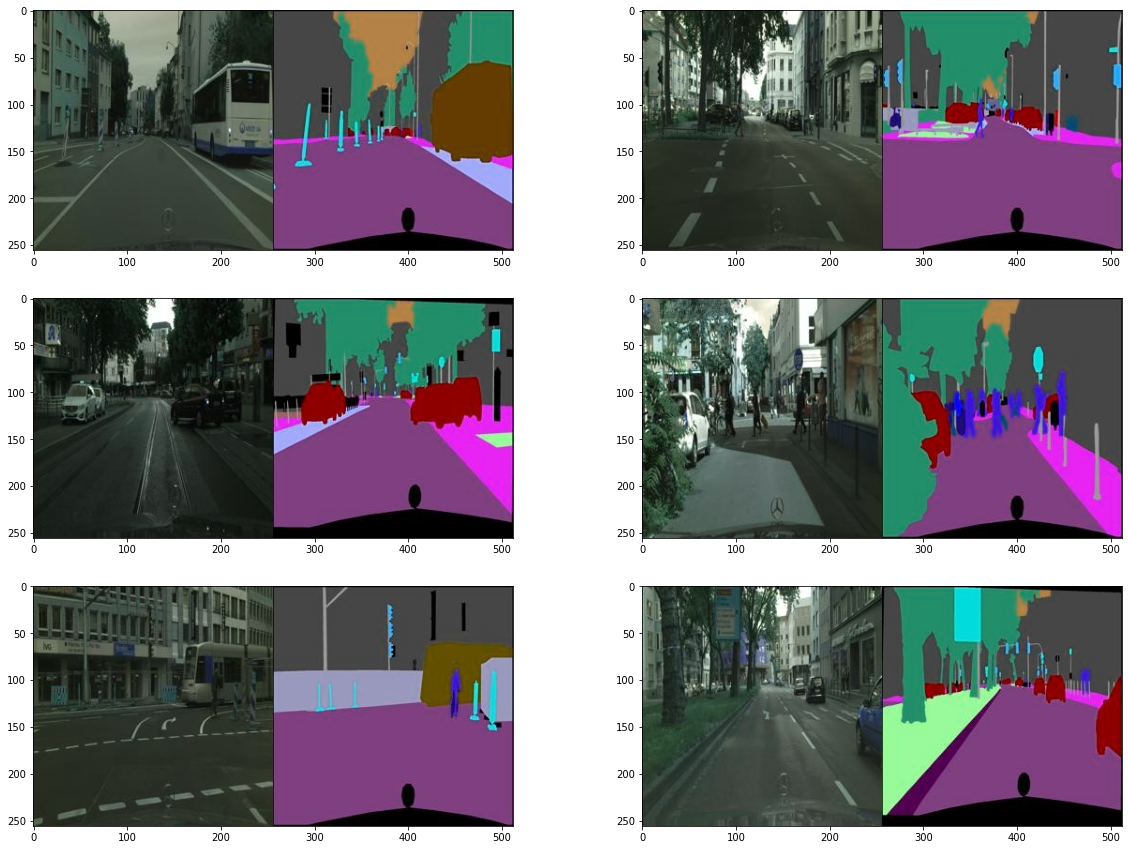

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

하나의 이미지에 실제 사진과 segmentation 이미지가 함께 포함되어 있습니다. 
이미지 하나를 열어서 크기를 확인해봅니다.

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


(256, 512, 3)으로 확인되었습니다. 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할합니다. 

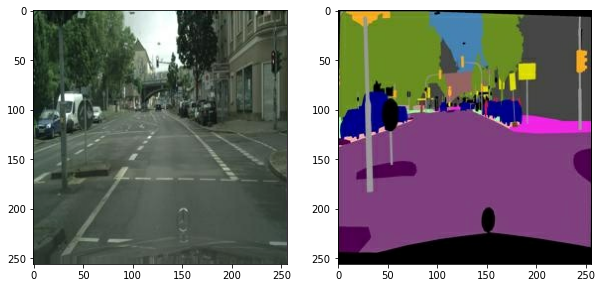

In [4]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

첫번째 사진을 다음 단계에서 구성할 Pix2Pix 모델에 입력하여 두번째 그림과 같은 이미지를 생성하는 것이 목표입니다. 


이미지 개수가 1000개밖에 안되기 때문에 augmentation을 적용합니다. 

In [5]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


appy_augmentation함수에서 다음과 같은 과정이 진행됩니다.
1. 두 이미지가 채널 축으로 연결됩니다. (tf.concat)
2. 앞선 결과에 50%의 확률로 Reflection padding 혹은 constant padding이 30 픽셀의 pad width 만큼 적용됩니다. (tf.pad)
3. 앞선 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)
4. 앞선 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
5. 앞선 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)
6. 앞선 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)

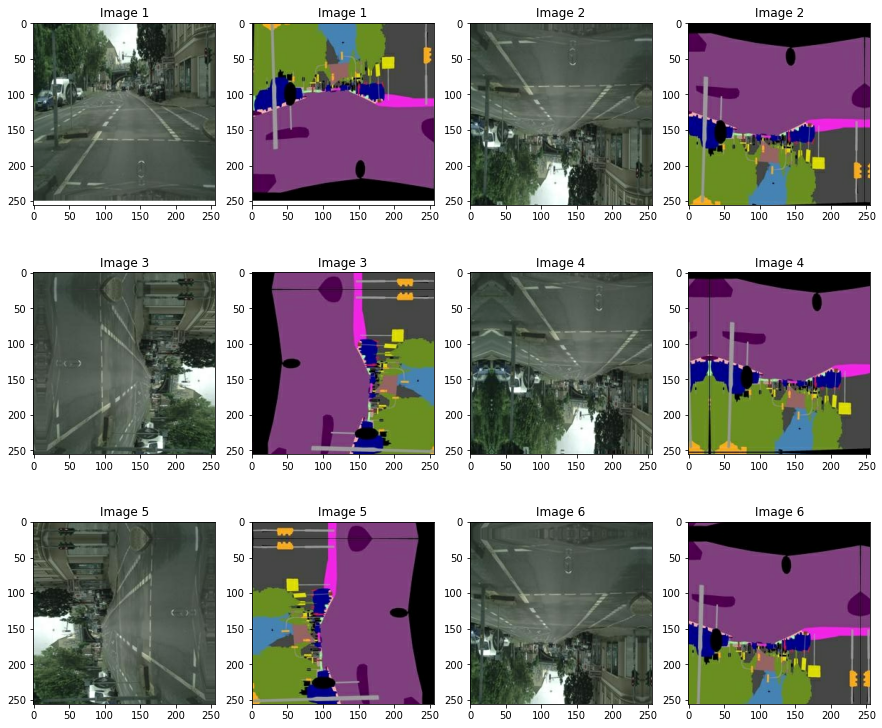

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

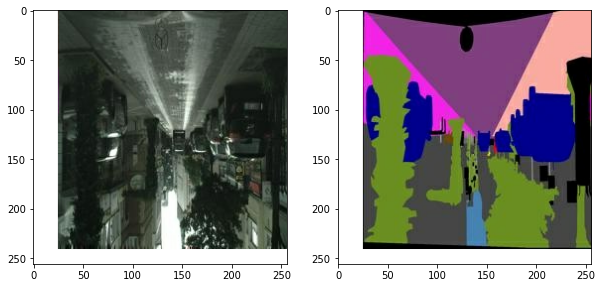

In [7]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## (2) Generator 구성하기
---
Pix2Pix 구조를 구현합니다. Tensorflow의 Subclassing 방법을 이용해 모델을 만듭니다. 

### Generator의 구성요소
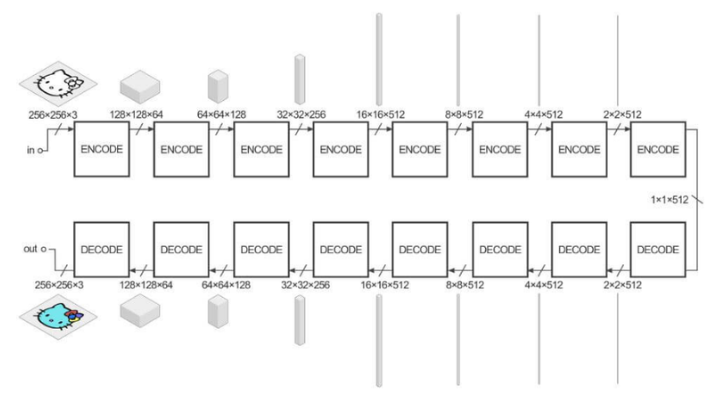

'in'이라고 쓰여진 입력부터 윗줄 화살표를 따라가면 계산된 결과의 (width, height)크기가 점점 절반씩 줄어들어 최종적으로 (1, 1)이 되고, 채널의 수가 512까지 늘어납니다. 윗줄의 입력부터 시작해서 (1, 1, 512)까지 크기를 출력하는 곳 까지가 Encoder 부분입니다. 


아랫줄은 (width, height)가 2배씩 늘어나서 (256, 256)이 되고, 채널의 수는 점점 줄어들어 처음과 같은 3채널이 됩니다. 이 부분이 Decoder 부분입니다. 

### Generator 구현하기

Convolution -> BatchNorm -> LeakyReLU 3개의 레이어로 구성된 기본적인 레이어로 구성된 기본적인 블록을 다음과 같이 하나의 레이어로 만듭니다. 

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


__init__()매서드에서 n_filters, use_bn을 설정하여 사용할 필터 개수와 BatchNorm 사용 여부를 결정할 수 있습니다. Convolution layer에서 필터크기 4, stride 2로 고정하였고. LeakyReLU의 slope coefficient를 0.2로 고정하였습니다. (Encoder 사용할 기본 블록 구성)

In [9]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [10]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

Decoder를 구성하기 위해 기본 블록을 정의하고, 이 블록을 여러번 반복하여 Decoder를 만듭니다. 

In [11]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [12]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

처음 3개의 블록에서먼 Dropout을 사용했으며, 마지막 convolution에는 3개의 필터를 사용해 출력합니다. (1, 1, 512)크기의 데이터를 입력했을 때 다음과 같이 (256, 256, 3)이 출력됩니다. 

위의 구성한 Encoder와 Decoder를 연결하면 Encoder에서 (256, 256, 3) 입력이 (1, 1, 512)로 변환되고, Decoder를 통과해서 다시 원래 크기인 (256, 256, 3)크기로 돌아옵니다. 사진을 입력으로 이런 연산과정을 통해 segmentation 이미지 출력을 얻을 수 있습니다. 


tf.keras.Model 을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성합니다. 

In [13]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


Generator를 잘 학습시키기 위해서 39,087,360개의 파라미터를 잘 학습시켜야 합니다;;

## (3) Generator 재구성하기
---

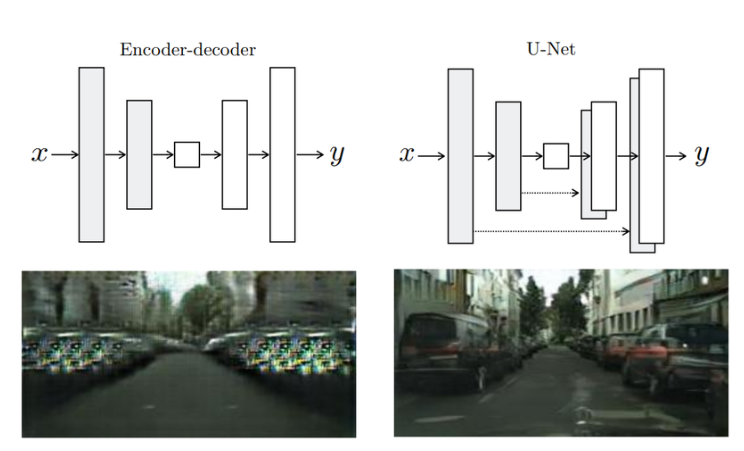

이전 단계에서 구현했던 Generator는 위 그림의 Encoder-Decoder 구조 입니다. Encoder-Decoder 구조에 비해 Encoder와 Decoder 사이를 skip connection으로 연결한 U-Net 구조를 사용한 결과가 훨씬 더 좋은 성능을 보입니다. 

조금 수정하여 U-Net구조를 만들고 실험해보았습니다. 


Encoder 및 Decoder에 사용되는 기본적인 블록은 이전과 같이 구현합니다. 

In [14]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [15]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [16]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

## (4) Discriminator 구성하기
---
조금 더 사실적인 이미지를 생성하기 위해 Pix2Pix를 완성시키기 위해 Discriminator가 필요합니다. 


### Discriminator의 구성요소 알아보기
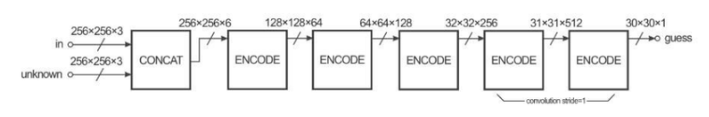

Discriminator는 2개의 입력 ('in', 'unknown')을 받아 연결(concat)한 후 Encode라고 쓰인 5개의 블록을 통과합니다. 


Discriminator에 사용할 기본적인 블록부터 만듭니다. 

In [17]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


1. (128,128,32) 크기의 입력이 layers.ZeroPadding2D()를 통과하면, width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어납니다. 출력 : (130,130,32)
2. 패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 width 및 height 가 3씩 줄어듭니다. 이는 OutSize=(InSize+2∗PadSize−FilterSize)/Stride+1 의 식으로 계산할 수 있습니다. 채널 수는 사용한 필터 개수와 같습니다. 출력 : (127,127,64)
3. 이 외 다른 레이어(BatchNorm, LeakyReLU)는 출력의 크기에 영향을 주지 않습니다.

In [18]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [19]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [20]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

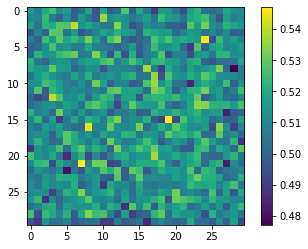

In [21]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## (5) 학습 및 테스트 하기
---

일반적인 GAN의 손실함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성해냈습니다. 

In [22]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


* Generator의 손실 함수 (위 코드의 get_gene_loss)는 총 3개의 입력이 있습니다. 이 중 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용합니다. 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산합니다.

* Discriminator의 손실 함수 (위 코드의 get_disc_loss)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값입니다. Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교합니다.


Optimizer는 논문과 동일하게 아래와 같이 설정합니다.

In [23]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


하나의 배치크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정은 다음과 같이 구현합니다.

In [24]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


논문에서 손실을 다음과 같이 정의합니다. 

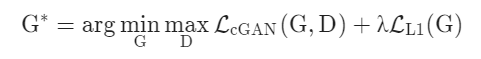

람다는 학습과정에서 L1 손실을 얼마나 반영할 것인지를 나타내고, 논문에서는 람다를 100으로 설정했습니다. 

In [25]:
EPOCHS = 10

generator_loss_list=[]
L1_loss_list=[]
Discriminator_loss_list=[]

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
            generator_loss_list.append(g_loss.numpy())
            L1_loss_list.append(l1_loss.numpy())
            Discriminator_loss_list.append(d_loss.numpy())

EPOCH[1] - STEP[10]                     
Generator_loss:0.8964                     
L1_loss:0.3577                     
Discriminator_loss:1.1979

EPOCH[1] - STEP[20]                     
Generator_loss:1.1212                     
L1_loss:0.3432                     
Discriminator_loss:0.9986

EPOCH[1] - STEP[30]                     
Generator_loss:1.5821                     
L1_loss:0.2864                     
Discriminator_loss:0.9344

EPOCH[1] - STEP[40]                     
Generator_loss:1.5536                     
L1_loss:0.2749                     
Discriminator_loss:0.7979

EPOCH[1] - STEP[50]                     
Generator_loss:1.4472                     
L1_loss:0.2209                     
Discriminator_loss:0.5859

EPOCH[1] - STEP[60]                     
Generator_loss:1.9909                     
L1_loss:0.2670                     
Discriminator_loss:0.4686

EPOCH[1] - STEP[70]                     
Generator_loss:2.1020                     
L1_loss:0.2285                    

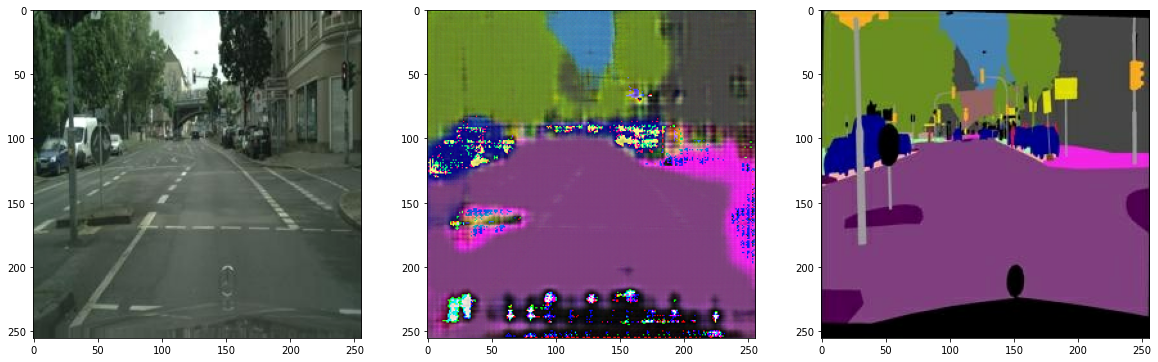

In [26]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

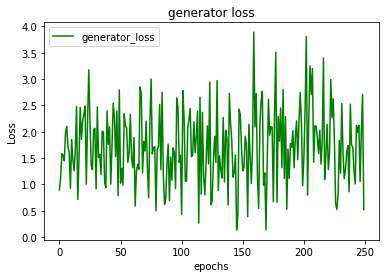

In [27]:
import matplotlib.pyplot as plt
import numpy as np

epochs = [i for i in range(len(generator_loss_list))]
plt.plot(epochs, generator_loss_list, 'g', label='generator_loss')
plt.title('generator loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

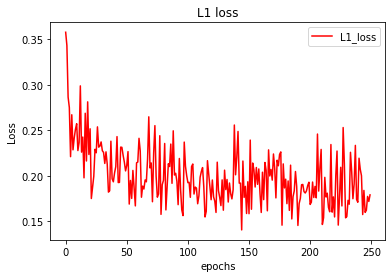

In [29]:
epochs = [i for i in range(len(L1_loss_list))]
plt.plot(epochs, L1_loss_list, 'r', label='L1_loss')
plt.title('L1 loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

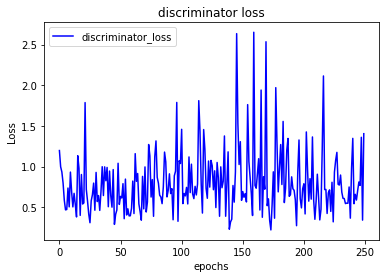

In [30]:
epochs = [i for i in range(len(Discriminator_loss_list))]
plt.plot(epochs, Discriminator_loss_list, 'b', label='discriminator_loss')
plt.title('discriminator loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 회고

* epoch수를 10회밖에 설정하지 않았기 때문에 L1_loss 빼고는 감소하는 형태를 아직 볼수는 없었습니다. 시간과 충분한 성능의 GPU가 주어진다면 에포크 수를 더 늘려서 실험해보고 싶습니다.
* 도로이미지를 segmentation을 해 본 결과 실제 segmentation 이미지보다 경계선이 분명하지 않고, 제대로 분류해내재 못한 클래스도 있었지만, 10에포크를 실험한 결과치고는 대략적인 형태가 괜찮게 나타난 것으로 보입니다.  